<a href="https://colab.research.google.com/github/Allen9809/dl-cnn-googlenet-car_image_classification/blob/main/dl_cnn_car_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms

import time
import os
import tqdm
import PIL.Image as Image
from IPython.display import display

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name(device))

cuda:0
Tesla T4


# Part 0: Introduction



This project focuses on car classification using the Stanford Car Dataset, which includes 16,185 images categorized into 196 classes based on Make, Model, and Year. The dataset is split into 8,144 training images and 8,041 testing images.

Training a deep learning model directly on this dataset is challenging due to the limited number of images per class. To address this, the project utilizes transfer learning—a technique where a pretrained model from ImageNet is we fine-tuned on the car dataset. We aim to develop a car classifier by fine-tuning a pretrained model. All layers will be adjusted, and the final fully connected layer will be replaced for specific classification tasks.

- Training: 8,144 images (average 41.5 per class).

- Testing: 8,041 images (average 41.0 per class).

# Part 1: Data Loading

## Part 1.1: Load and extract data from Colab

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp ./drive/MyDrive/colab_project/stanford_car_dataset.zip ./

In [ ]:
%%time

!mkdir ./stanford_car_dataset
!unzip stanford_car_dataset.zip -d ./stanford_car_dataset

流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: ./stanford_car_dataset/car_data/car_data/train/Chrysler Aspen SUV 2009/04772.jpg  
  inflating: ./stanford_car_dataset/car_data/car_data/train/Chrysler Aspen SUV 2009/05544.jpg  
  inflating: ./stanford_car_dataset/car_data/car_data/train/Chrysler Aspen SUV 2009/05728.jpg  
  inflating: ./stanford_car_dataset/car_data/car_data/train/Chrysler Aspen SUV 2009/05860.jpg  
  inflating: ./stanford_car_dataset/car_data/car_data/train/Chrysler Aspen SUV 2009/06146.jpg  
  inflating: ./stanford_car_dataset/car_data/car_data/train/Chrysler Aspen SUV 2009/06157.jpg  
  inflating: ./stanford_car_dataset/car_data/car_data/train/Chrysler Aspen SUV 2009/06332.jpg  
  inflating: ./stanford_car_dataset/car_data/car_data/train/Chrysler Aspen SUV 2009/06441.jpg  
  inflating: ./stanford_car_dataset/car_data/car_data/train/Chrysler Aspen SUV 2009/06447.jpg  
  inflating: ./stanford_car_dataset/car_data/car_data/train/Chrysler Aspen SUV 2009/06590.jpg  
  inflating: 

## Part 1.2: transform data for training and testing purpose

In [ ]:
# Directory where the dataset is stored
dataset_dir = "stanford_car_dataset/car_data/car_data/"

# Image transformation and normalization parameters
width, height = 224, 224
mean = [0.485, 0.456, 0.406]  # Mean values for normalization (from ImageNet)
std = [0.229, 0.224, 0.225]   # Standard deviation values for normalization (from ImageNet)

# Define transformations for training and testing data
train_tfms = transforms.Compose([
    transforms.Resize((width, height)),
    # Uncomment for data augmentation
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

test_tfms = transforms.Compose([
    transforms.Resize((width, height)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# Create datasets
train_dataset = torchvision.datasets.ImageFolder(root=dataset_dir + "train", transform=train_tfms)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)

test_dataset = torchvision.datasets.ImageFolder(root=dataset_dir + "test", transform=test_tfms)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# Print dataset statistics
print(f"Training dataset size: {len(train_dataset)}")
print(f"Testing dataset size: {len(test_dataset)}")
print(f"Number of classes: {len(train_dataset.classes)}")

Training dataset size: 8144
Testing dataset size: 8041
Number of classes: 196


# Part 2: Data Modeling

## Part 2.1: define the model training function

In [ ]:
def train_model(model, criterion, optimizer, scheduler, trainloader, n_epochs=5, device='cuda'):
    """
    Trains a deep learning model using the specified criterion, optimizer, scheduler, and data loader.

    Args:
    - model (torch.nn.Module): The deep learning model to train.
    - criterion (torch.nn.Module): The loss function used for optimization.
    - optimizer (torch.optim.Optimizer): The optimizer used for updating model parameters.
    - scheduler (torch.optim.lr_scheduler._LRScheduler): Scheduler to adjust learning rate based on metrics.
    - trainloader (torch.utils.data.DataLoader): DataLoader for training data.
    - n_epochs (int): Number of epochs to train the model (default: 5).
    - device (str): Device to run the training on ('cuda' or 'cpu') (default: 'cuda').

    Returns:
    - model (torch.nn.Module): Trained deep learning model.
    - losses (list): List of training losses per epoch.
    - accuracies (list): List of training accuracies per epoch.
    - test_accuracies (list): List of test accuracies per epoch.
    """
    model.to(device)
    losses = []
    accuracies = []
    test_accuracies = []

    # set the model to train mode initially
    model.train()

    for epoch in tqdm.tqdm(range(n_epochs), desc='Training'):
        since = time.time()
        running_loss = 0.0
        running_correct = 0.0

        for i, data in enumerate(trainloader, 0):
            # get the inputs and assign them to the appropriate device (cuda)
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward pass
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            # calculate loss
            loss = criterion(outputs, labels)

            # backward + optimize
            loss.backward()
            optimizer.step()

            # calculate statistics
            running_loss += loss.item()
            running_correct += (predicted == labels).sum().item()

        # calculate epoch statistics
        epoch_duration = time.time() - since
        epoch_loss = running_loss / len(trainloader) # average loss per epoch
        epoch_acc = 100 * running_correct / len(trainloader.dataset) # classification correctness rate

        print(f"Epoch [{epoch+1}/{n_epochs}], "
              f"Duration: {epoch_duration:.2f}s, "
              f"Loss: {epoch_loss:.4f}, "
              f"Accuracy: {epoch_acc:.2f}%")

        losses.append(epoch_loss)
        accuracies.append(epoch_acc)

        # evaluate on test data, eval mode
        model.eval()
        test_acc = eval_model(model, testloader, device)
        test_accuracies.append(test_acc)

        # adjust learning rate based on validation accuracy
        scheduler.step(test_acc)

        # switch back to train mode
        model.train()

    print('Finished Training')
    return model, losses, accuracies, test_accuracies


## Part 2.2: define the model evaluation function

In [ ]:

def eval_model(model, testloader, device='cuda'):
    """
    Evaluates the performance of a deep learning model on the test dataset.

    Args:
    - model (torch.nn.Module): The deep learning model to evaluate.
    - testloader (torch.utils.data.DataLoader): DataLoader for test data.
    - device (str): Device to run evaluation on ('cuda' or 'cpu') (default: 'cuda').

    Returns:
    - test_acc (float): Accuracy of the model on the test dataset.
    """
    model.eval()
    correct = 0.0
    total = 0.0

    with torch.no_grad(): # efficiency
        for i, data in enumerate(testloader, 0):
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_acc = 100.0 * correct / total
    print('Accuracy of the network on the test images: %.2f %%' % (test_acc))
    return test_acc


## Part 2.3: define parameters

In [ ]:
NUM_CAR_CLASSES = 196

model_ft = models.alexnet(pretrained=True)  # also we can try resnet34(pretrained=True)

# Freezing model parameters and defining the fully connected network to be attached to the model
for param in model_ft.parameters():
    param.require_grad = False

# replace the last fc layer with an untrained one (requires grad by default)
# num_ftrs = model_ft.classifier[-1].in_features # for alexnet, classifier is the last layer
# model_ft.classifier[-1] = nn.Linear(num_ftrs, NUM_CAR_CLASSES)

# for GoogleNet
model_ft = models.googlenet(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, NUM_CAR_CLASSES)


# for resnet34
# num_ftrs = model_ft.fc.in_features
# model_ft.fc = nn.Linear(num_ftrs, NUM_CAR_CLASSES)

# put the model on the GPUs to speed up
model_ft = model_ft.to(device)

# # uncomment this block for half-precision model
# model_ft = model_ft.half()
# for layer in model_ft.modules():
#     if isinstance(layer, nn.BatchNorm2d):
#         layer.float()

criterion = nn.CrossEntropyLoss()

# optimizer = optim.Adam(model_ft.parameters(), lr=0.01)
optimizer = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)

"""
probably not the best metric to track, but we are tracking the training accuracy and measuring whether
it increases by at least 0.9 per epoch; if it hasn't increased by 0.9, reduce the lr by 0.1x.
However, in this model, it did not benefit a lot.
"""

lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 147MB/s]


## Part 2.4: model training

In [ ]:
model_ft, training_losses, training_accs, test_accs = train_model(model_ft, criterion, optimizer, lrscheduler, trainloader, n_epochs=10, device = device)

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [1/10], Duration: 68.50s, Loss: 0.6288, Accuracy: 85.66%


Training:  10%|█         | 1/10 [02:08<19:16, 128.46s/it]

Accuracy of the network on the test images: 66.94 %
Epoch [2/10], Duration: 68.23s, Loss: 0.2995, Accuracy: 94.60%


Training:  20%|██        | 2/10 [04:17<17:11, 128.91s/it]

Accuracy of the network on the test images: 73.80 %
Epoch [3/10], Duration: 68.61s, Loss: 0.1343, Accuracy: 98.07%


Training:  30%|███       | 3/10 [06:27<15:06, 129.54s/it]

Accuracy of the network on the test images: 78.15 %
Epoch [4/10], Duration: 66.83s, Loss: 0.0687, Accuracy: 99.24%


Training:  40%|████      | 4/10 [08:38<12:59, 129.93s/it]

Accuracy of the network on the test images: 79.36 %
Epoch [5/10], Duration: 68.08s, Loss: 0.0426, Accuracy: 99.75%


Training:  50%|█████     | 5/10 [10:47<10:48, 129.71s/it]

Accuracy of the network on the test images: 81.33 %
Epoch [6/10], Duration: 68.71s, Loss: 0.0348, Accuracy: 99.78%


Training:  60%|██████    | 6/10 [12:57<08:38, 129.66s/it]

Accuracy of the network on the test images: 81.13 %
Epoch [7/10], Duration: 68.92s, Loss: 0.0305, Accuracy: 99.83%


Training:  70%|███████   | 7/10 [15:07<06:29, 129.68s/it]

Accuracy of the network on the test images: 81.18 %
Epoch [8/10], Duration: 67.88s, Loss: 0.0296, Accuracy: 99.78%


Training:  80%|████████  | 8/10 [17:15<04:18, 129.14s/it]

Accuracy of the network on the test images: 81.47 %
Epoch [9/10], Duration: 68.47s, Loss: 0.0264, Accuracy: 99.86%


Training:  90%|█████████ | 9/10 [19:24<02:09, 129.12s/it]

Accuracy of the network on the test images: 81.28 %
Epoch [10/10], Duration: 68.70s, Loss: 0.0267, Accuracy: 99.83%


Training: 100%|██████████| 10/10 [21:33<00:00, 129.33s/it]

Accuracy of the network on the test images: 81.41 %
Finished Training


Text(0.5, 1.0, 'Test acc')

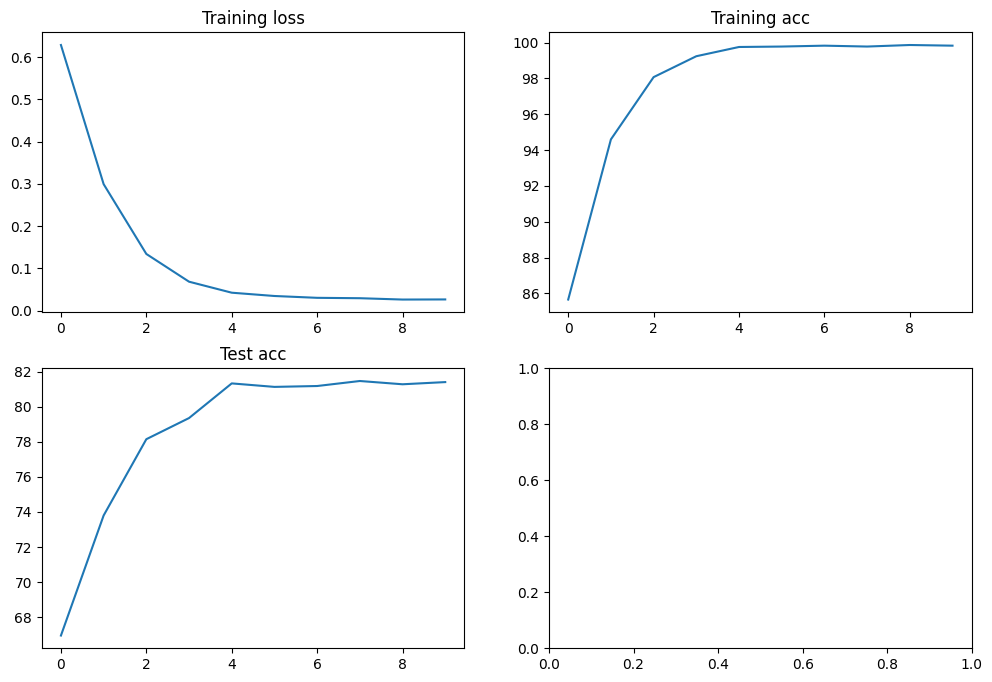

In [ ]:
# plot the stats

f, axarr = plt.subplots(2,2, figsize = (12, 8))
axarr[0, 0].plot(training_losses)
axarr[0, 0].set_title("Training loss")
axarr[0, 1].plot(training_accs)
axarr[0, 1].set_title("Training acc")
axarr[1, 0].plot(test_accs)
axarr[1, 0].set_title("Test acc")

## Part 2.5: visulization the model training process

As we can see the model reached 90% training accuracy by epoch 4.


Text(0.5, 1.0, 'Test acc')

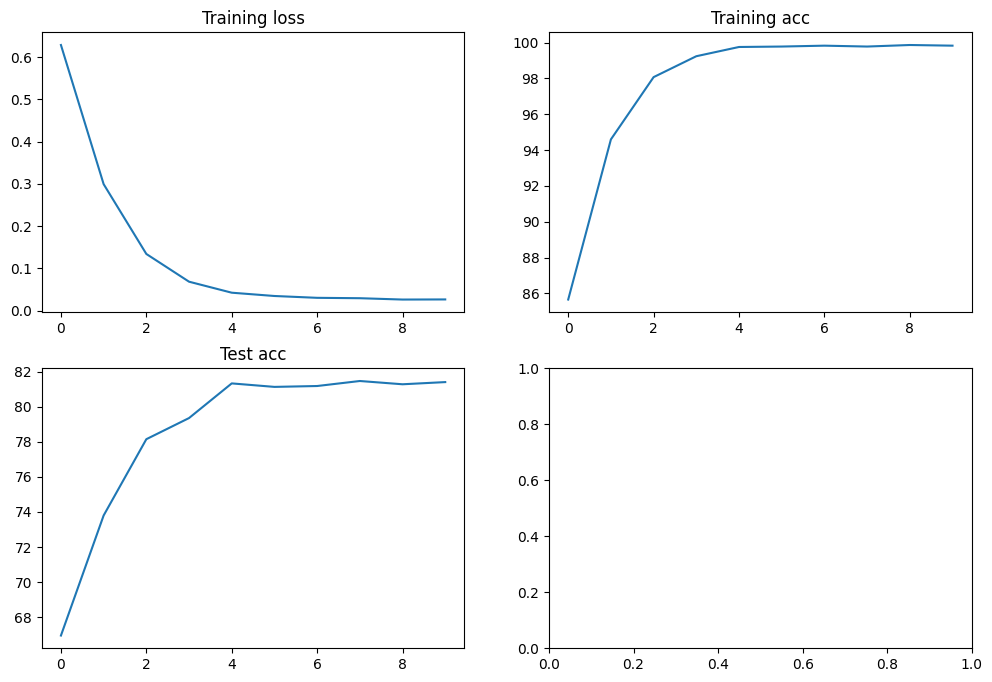

In [ ]:
# plot the stats

f, axarr = plt.subplots(2,2, figsize = (12, 8))
axarr[0, 0].plot(training_losses)
axarr[0, 0].set_title("Training loss")
axarr[0, 1].plot(training_accs)
axarr[0, 1].set_title("Training acc")
axarr[1, 0].plot(test_accs)
axarr[1, 0].set_title("Test acc")

# Part 3: Model Evaluation (on single images)

Next we can use the model on our own images. For that we need to tie the class numbers for which the model returns probablities with the names of those classes.


In [ ]:
# tie the class indices to their names

def find_classes(dir):
    classes = os.listdir(dir)
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx
classes, c_to_idx = find_classes(dataset_dir+"train")

In [ ]:
# test the model on random images
# switch the model to evaluation mode to make dropout and batch norm work in eval mode
model_ft.eval()

# transforms for the input image
loader = transforms.Compose([transforms.Resize((400, 400)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
image = Image.open(dataset_dir+"test/Mercedes-Benz C-Class Sedan 2012/01977.jpg")
image = loader(image).float()
image = torch.autograd.Variable(image, requires_grad=True)
image = image.unsqueeze(0)
image = image.cuda()
output = model_ft(image)
conf, predicted = torch.max(output.data, 1)

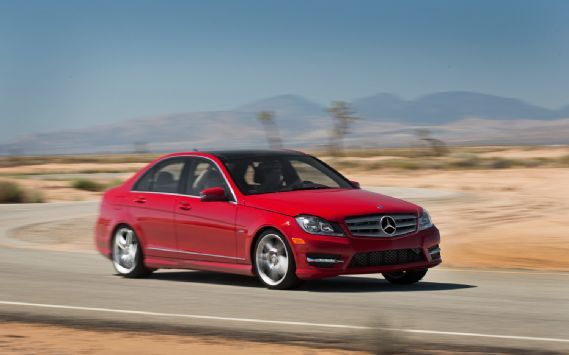

Mercedes-Benz C-Class Sedan 2012 confidence:  3.786259889602661


In [ ]:
# get the class name of the prediction
display(Image.open(dataset_dir+"test/Mercedes-Benz C-Class Sedan 2012/01977.jpg"))
print(classes[predicted.item()], "confidence: ", conf.item())

# Part 4: Model Saving and Re-loading

In [ ]:
PATH = 'car_model.pth'
# torch.save(model_ft.state_dict(), PATH)
torch.save(model_ft, PATH)

In [ ]:
model_loaded = torch.load(PATH)

# Part 5: Connect to a Web App Service using Steamlit

In [ ]:
%%writefile app.py

import streamlit as st
import torch
from torchvision import transforms
from PIL import Image

# load model artifact
model = torch.load(PATH)
model.eval()

# define input
preprocess = transforms.Compose([
    transforms.Resize((400, 400)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def model_predict(img, model):
    img = preprocess(img).unsqueeze(0)
    img = loader(img).float()
    # img = torch.autograd.Variable(img, requires_grad=True)
    img = img.unsqueeze(0)
    img = img.cuda()

    with torch.no_grad():
        preds = model(img)

    return preds

st.title("CNN Image Classification using Pretrained GoogleNet")

uploaded_file = st.file_uploader("Choose an image...", type="jpg")

if uploaded_file is not None:
    img = Image.open(uploaded_file)
    st.image(img, caption='Uploaded Image.', use_column_width=True)
    st.write("")
    st.write("Classifying...")

    preds = model_predict(img, model)
    # _, predicted = torch.max(output.data, 1)
    result = torch.argmax(preds, dim=1).item()
    st.write(f"Result: {result}")


Writing app.py


To deploy machine learning models and applications, one can save the trained model using PyTorch or similar frameworks, and the application code as a Python script (e.g., app.py). Using Streamlit facilitates creating interactive web interfaces for showcasing model predictions or data visualizations. Leveraging tunneling services like ngrok enables exposing local applications via public URLs, ideal for testing and sharing during development. These tools streamline the process of deploying and sharing machine learning solutions, enhancing accessibility and usability.